In [1]:
# # 03 - Feature Selection
# ## Identifying Most Important Features for Heart Disease Prediction
# 
# ### Objectives:
# - Use Random Forest feature importance
# - Apply Recursive Feature Elimination (RFE)
# - Use Chi-Square test for feature significance
# - Select optimal feature subset

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib

In [13]:
# Load preprocessed data
X_clean = pd.read_csv('data/heart_disease_cleaned_features.csv')
y_clean = pd.read_csv('data/heart_disease_cleaned_target.csv')['target']

print("Data loaded successfully!")
print(f"Features shape: {X_clean.shape}")

Data loaded successfully!
Features shape: (303, 13)


In [35]:
def perform_feature_selection(X, y, n_features=8):
    """Perform comprehensive feature selection using multiple methods"""
    
    # Split data for feature selection
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    results = {}
    
    # Method 1: Random Forest Feature Importance
    print("1. Random Forest Feature Importance...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    results['rf_importance'] = feature_importance
    
    # Method 2: Recursive Feature Elimination (RFE)
    print("2. Recursive Feature Elimination...")
    rfe = RFE(
        estimator=LogisticRegression(max_iter=1000, random_state=42), 
        n_features_to_select=n_features
    )
    rfe.fit(X_train, y_train)
    
    rfe_results = pd.DataFrame({
        'feature': X.columns,
        'rfe_ranking': rfe.ranking_,
        'rfe_selected': rfe.support_
    }).sort_values('rfe_ranking')
    
    results['rfe'] = rfe_results
    
    # Method 3: ANOVA F-test (works with negative values)
    print("3. ANOVA F-test...")
    f_test_selector = SelectKBest(f_classif, k=n_features)
    f_test_selector.fit(X_train, y_train)
    
    f_test_results = pd.DataFrame({
        'feature': X.columns,
        'f_score': f_test_selector.scores_,
        'f_pvalue': f_test_selector.pvalues_,
        'f_selected': f_test_selector.get_support()
    }).sort_values('f_score', ascending=False)
    
    results['f_test'] = f_test_results
    
    # Method 4: Mutual Information
    print("4. Mutual Information...")
    mi_selector = SelectKBest(mutual_info_classif, k=n_features)
    mi_selector.fit(X_train, y_train)
    
    mi_results = pd.DataFrame({
        'feature': X.columns,
        'mi_score': mi_selector.scores_,
        'mi_selected': mi_selector.get_support()
    }).sort_values('mi_score', ascending=False)
    
    results['mutual_info'] = mi_results
    
    # Combine all methods - FIXED VERSION
    combined_scores = pd.DataFrame({'feature': X.columns})
    
    # Debug: Check if all DataFrames have the same features in the same order
    print(f"Features in X: {list(X.columns)}")
    print(f"Features in rf_importance: {list(feature_importance['feature'])}")
    print(f"Features in rfe_results: {list(rfe_results['feature'])}")
    
    # Set feature as index for proper alignment
    rf_importance_idx = feature_importance.set_index('feature')
    rfe_results_idx = rfe_results.set_index('feature')
    f_test_results_idx = f_test_results.set_index('feature')
    mi_results_idx = mi_results.set_index('feature')
    
    # Get scores from different methods with proper alignment
    combined_scores['rf_score'] = combined_scores['feature'].map(rf_importance_idx['importance'])
    combined_scores['rfe_ranking'] = combined_scores['feature'].map(rfe_results_idx['rfe_ranking'])
    combined_scores['f_score'] = combined_scores['feature'].map(f_test_results_idx['f_score'])
    combined_scores['mi_score'] = combined_scores['feature'].map(mi_results_idx['mi_score'])
    
    # Check for any remaining NaN values
    print("\nNaN values after mapping:")
    for col in ['rf_score', 'rfe_ranking', 'f_score', 'mi_score']:
        nan_count = combined_scores[col].isna().sum()
        print(f"{col}: {nan_count} NaN values")
    
    # Handle any potential NaN values
    combined_scores['rf_score'] = combined_scores['rf_score'].fillna(0)
    combined_scores['rfe_ranking'] = combined_scores['rfe_ranking'].fillna(combined_scores['rfe_ranking'].max() + 1)
    combined_scores['f_score'] = combined_scores['f_score'].fillna(0)
    combined_scores['mi_score'] = combined_scores['mi_score'].fillna(0)
    
    # Normalize scores from different methods
    rf_max = combined_scores['rf_score'].max()
    combined_scores['rf_normalized'] = combined_scores['rf_score'] / rf_max if rf_max > 0 else 0
    
    # For RFE, lower ranking is better (1 is best)
    rfe_max_rank = combined_scores['rfe_ranking'].max()
    combined_scores['rfe_score'] = 1 - (combined_scores['rfe_ranking'] - 1) / max(rfe_max_rank - 1, 1)
    
    f_max = combined_scores['f_score'].max()
    combined_scores['f_test_normalized'] = combined_scores['f_score'] / f_max if f_max > 0 else 0
    
    mi_max = combined_scores['mi_score'].max()
    combined_scores['mi_normalized'] = combined_scores['mi_score'] / mi_max if mi_max > 0 else 0
    
    # Combined score (average of normalized scores)
    combined_scores['combined_score'] = (
        combined_scores['rf_normalized'] + 
        combined_scores['rfe_score'] + 
        combined_scores['f_test_normalized'] + 
        combined_scores['mi_normalized']
    ) / 4
    
    combined_scores = combined_scores.sort_values('combined_score', ascending=False)
    results['combined'] = combined_scores
    
    return results

In [37]:
# Perform feature selection
feature_results = perform_feature_selection(X_clean, y_clean)

1. Random Forest Feature Importance...
2. Recursive Feature Elimination...
3. ANOVA F-test...
4. Mutual Information...
Features in X: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Features in rf_importance: ['thalach', 'cp', 'thal', 'ca', 'age', 'oldpeak', 'chol', 'trestbps', 'exang', 'slope', 'sex', 'restecg', 'fbs']
Features in rfe_results: ['sex', 'cp', 'fbs', 'thalach', 'exang', 'slope', 'ca', 'thal', 'trestbps', 'restecg', 'oldpeak', 'chol', 'age']

NaN values after mapping:
rf_score: 0 NaN values
rfe_ranking: 0 NaN values
f_score: 0 NaN values
mi_score: 0 NaN values


In [39]:
def visualize_feature_selection(results):
    """Visualize feature selection results"""
    
    combined_scores = results['combined']
    
    # Create a comprehensive visualization
    plt.figure(figsize=(18, 12))
    
    # Plot 1: Random Forest Importance
    plt.subplot(2, 3, 1)
    rf_top = results['rf_importance'].head(10)
    sns.barplot(data=rf_top, x='importance', y='feature')
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Importance Score')
    
    # Plot 2: RFE Rankings
    plt.subplot(2, 3, 2)
    rfe_selected = results['rfe'][results['rfe']['rfe_selected']]
    plt.barh(range(len(rfe_selected)), [1]*len(rfe_selected))
    plt.yticks(range(len(rfe_selected)), rfe_selected['feature'])
    plt.title('RFE Selected Features')
    plt.xlabel('Selected (1 = Yes)')
    
    # Plot 3: ANOVA F-scores
    plt.subplot(2, 3, 3)
    f_test_top = results['f_test'].head(10)
    sns.barplot(data=f_test_top, x='f_score', y='feature')
    plt.title('ANOVA F-test Scores')
    plt.xlabel('F-score')
    
    # Plot 4: Mutual Information Scores
    plt.subplot(2, 3, 4)
    mi_top = results['mutual_info'].head(10)
    sns.barplot(data=mi_top, x='mi_score', y='feature')
    plt.title('Mutual Information Scores')
    plt.xlabel('MI Score')
    
    # Plot 5: Combined Scores - Filter out NaN values
    plt.subplot(2, 3, 5)
    combined_top = combined_scores.dropna().head(12)  # Remove NaN values
    sns.barplot(data=combined_top, x='combined_score', y='feature')
    plt.title('Combined Feature Scores')
    plt.xlabel('Combined Score')
    
    # Plot 6: Correlation of scores - Filter out NaN values
    plt.subplot(2, 3, 6)
    score_columns = ['rf_normalized', 'rfe_score', 'f_test_normalized', 'mi_normalized']
    valid_scores = combined_scores[score_columns].dropna()  # Remove rows with NaN
    
    if not valid_scores.empty:
        score_correlation = valid_scores.corr()
        sns.heatmap(score_correlation, annot=True, cmap='coolwarm', center=0,
                    square=True, cbar_kws={"shrink": .8})
        plt.title('Feature Selection Methods Correlation')
    else:
        plt.text(0.5, 0.5, 'No valid data for correlation', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Correlation Matrix (No Valid Data)')
    
    plt.tight_layout()
    plt.show()
    
    # Display top features - Filter out NaN values
    valid_combined_scores = combined_scores.dropna()
    print("Top 10 Features by Combined Score:")
    print("=" * 50)
    if not valid_combined_scores.empty:
        for i, (_, row) in enumerate(valid_combined_scores.head(10).iterrows(), 1):
            print(f"{i:2d}. {row['feature']:15} Score: {row['combined_score']:.3f}")
    else:
        print("No valid features with calculated scores")
        print("Debug info:")
        print(f"NaN values in columns:")
        for col in combined_scores.columns:
            nan_count = combined_scores[col].isna().sum()
            print(f"  {col}: {nan_count} NaN values")

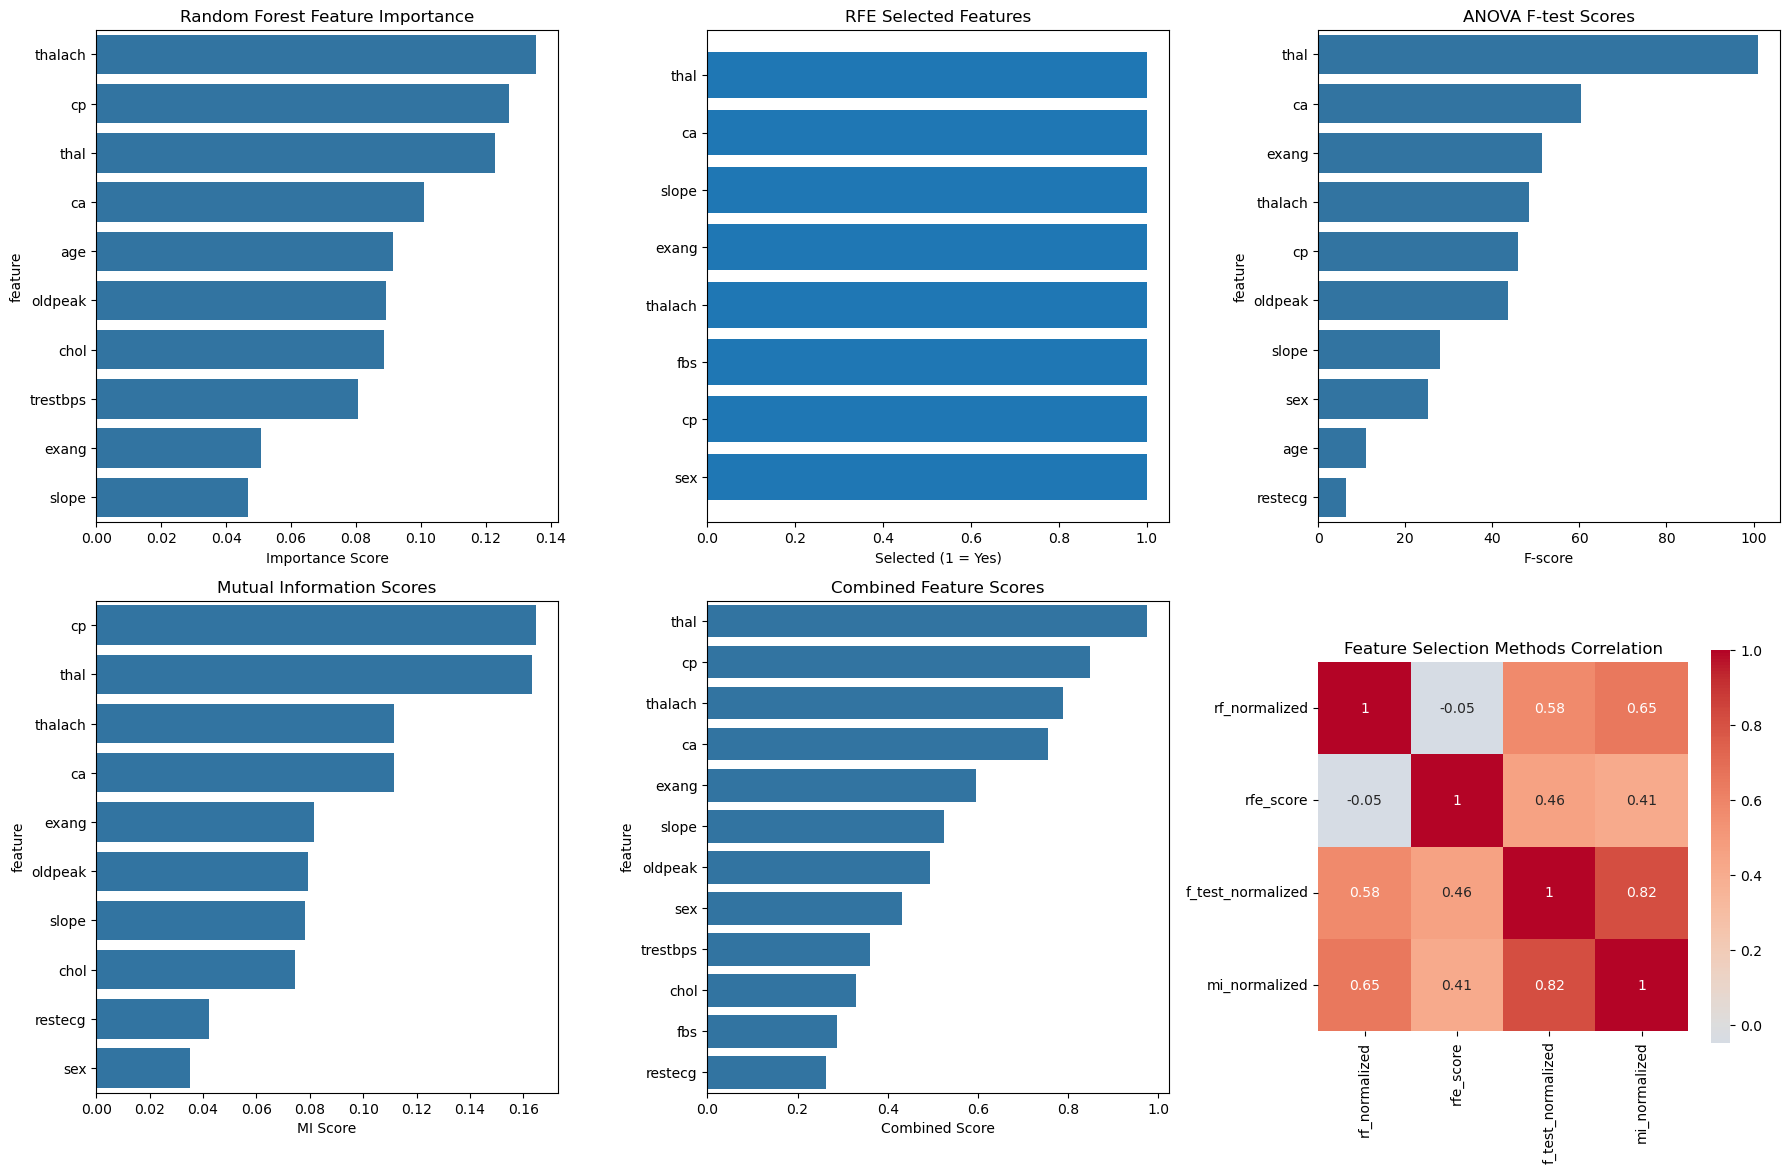

Top 10 Features by Combined Score:
 1. thal            Score: 0.975
 2. cp              Score: 0.848
 3. thalach         Score: 0.789
 4. ca              Score: 0.754
 5. exang           Score: 0.595
 6. slope           Score: 0.524
 7. oldpeak         Score: 0.493
 8. sex             Score: 0.432
 9. trestbps        Score: 0.360
10. chol            Score: 0.331


In [41]:
# Visualize results
visualize_feature_selection(feature_results)

In [43]:
def select_optimal_features(results, X, n_features=8):
    """Select optimal features based on combined scores"""
    
    combined_scores = results['combined']
    selected_features = combined_scores.head(n_features)['feature'].tolist()
    
    print(f"Selected {n_features} features:")
    for i, feature in enumerate(selected_features, 1):
        score = combined_scores[combined_scores['feature'] == feature]['combined_score'].values[0]
        print(f"{i:2d}. {feature:15} (Score: {score:.3f})")
    
    # Create reduced dataset
    X_reduced = X[selected_features]
    
    # Compare feature sets
    original_corr = X.corrwith(y_clean).abs().mean()
    reduced_corr = X_reduced.corrwith(y_clean).abs().mean()
    
    print(f"\nFeature Set Comparison:")
    print(f"Original features ({X.shape[1]}): Average absolute correlation with target: {original_corr:.3f}")
    print(f"Reduced features ({X_reduced.shape[1]}): Average absolute correlation with target: {reduced_corr:.3f}")
    
    return X_reduced, selected_features

In [45]:
# Select optimal features
X_selected, selected_features = select_optimal_features(feature_results, X_clean)

Selected 8 features:
 1. thal            (Score: 0.975)
 2. cp              (Score: 0.848)
 3. thalach         (Score: 0.789)
 4. ca              (Score: 0.754)
 5. exang           (Score: 0.595)
 6. slope           (Score: 0.524)
 7. oldpeak         (Score: 0.493)
 8. sex             (Score: 0.432)

Feature Set Comparison:
Original features (13): Average absolute correlation with target: 0.303
Reduced features (8): Average absolute correlation with target: 0.411


In [47]:
# Save selected features and dataset
X_selected.to_csv('data/heart_disease_selected_features.csv', index=False)

In [49]:
feature_selection_info = {
    'selected_features': selected_features,
    'feature_scores': feature_results['combined'].to_dict()
}
joblib.dump(feature_selection_info, 'models/feature_selection_info.pkl')

print("\nFeature selection completed!")
print(f"Original features: {X_clean.shape[1]}")
print(f"Selected features: {X_selected.shape[1]}")


Feature selection completed!
Original features: 13
Selected features: 8
